[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Classification Report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73      1302
           1       0.25      0.00      0.00       964

    accuracy                           0.57      2266
   macro avg       0.41      0.50      0.37      2266
weighted avg       0.44      0.57      0.42      2266



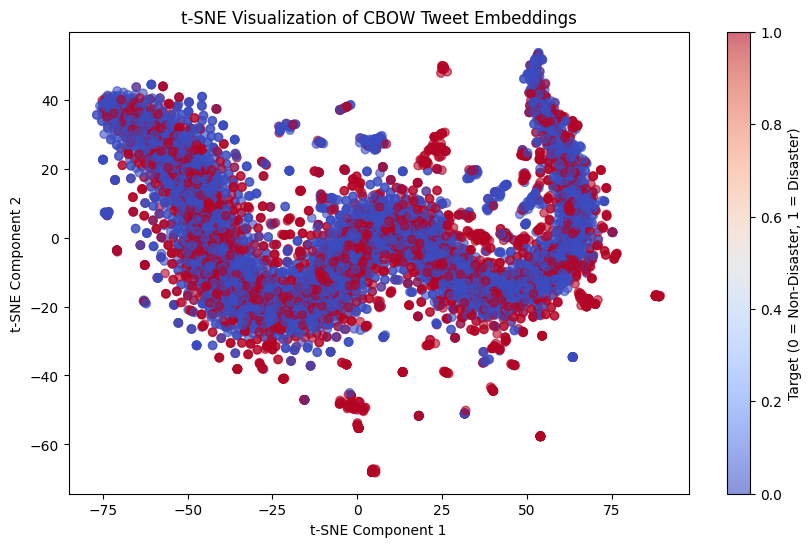

In [ ]:
# Required libraries
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
import re

# Load and clean data
df = pd.read_csv('/modified_tweets_dataset (1).csv')
stop_words = set(stopwords.words('english'))

# Preprocess tweets
def preprocess(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower().split()
    text = [word for word in text if word not in stop_words]
    return text

df['cleaned_text'] = df['text'].apply(preprocess)

# Train CBOW model
sentences = df['cleaned_text'].tolist()
cbow_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)  # sg=0 for CBOW

# Generate tweet embeddings by averaging word vectors
def get_tweet_embedding(tweet):
    vectors = [cbow_model.wv[word] for word in tweet if word in cbow_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

df['tweet_embedding'] = df['cleaned_text'].apply(get_tweet_embedding)

# Split into train and test
X = np.vstack(df['tweet_embedding'].values)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier (e.g., logistic regression or SVM)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualize embeddings with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

# Plot t-SNE with color indicating target
plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Target (0 = Non-Disaster, 1 = Disaster)')
plt.title("t-SNE Visualization of CBOW Tweet Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()
